# Redes Neurais Recorrentes

In [1]:
from rubianets import *

import re
from unidecode import unidecode
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Revisão da layer Embedding

Found 100 vocab compared to an allowed 90 size
Discarding a total of 10 less frequent words
Word counts: [('rato', 1), ('roeu', 1), ('roupa', 1), ('rei', 2), ('roma', 2)]
Most commom words: [('<OOV>', 1), (',', 2), ('olho', 3), ('burro', 4), ('santo', 5)]
Longest sentence (xbar+/-std): 40 (22+/-6)

Tokenized (example):
rato roeu roupa rei roma  ->  [23, 24, 25, 6, 7]

Preparing a simple embedding model
Model: "EmbeddingExploration"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 2)             200       
_________________________________________________________________
vectorizer (Flatten)         (None, 80)                0         
Total params: 200
Trainable params: 200
Non-trainable params: 0
______________________________________

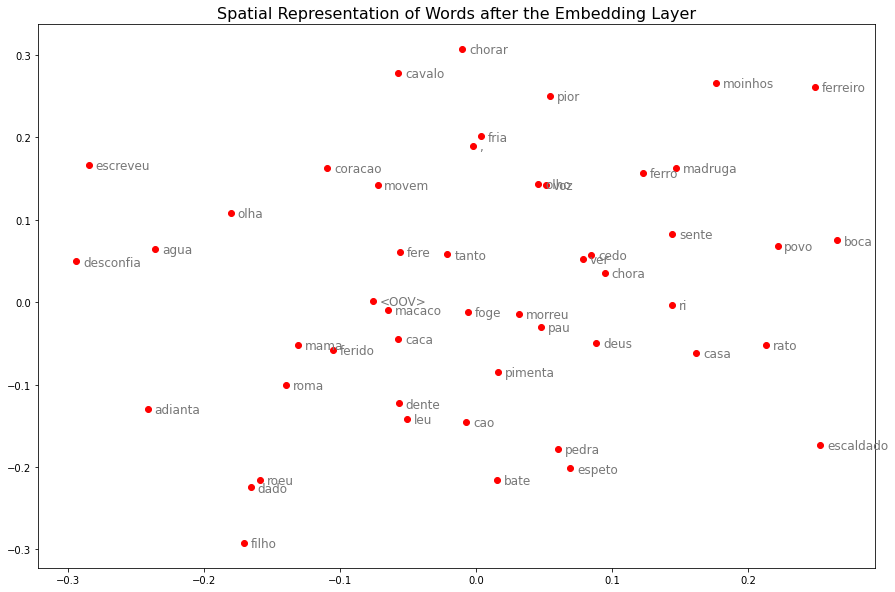

In [2]:
X = np.array(['O rato roeu a roupa do rei de Roma',
              'Quem tem boca vai a Roma',
              'Olho por olho, dente por dente',
              'Pimenta nos olhos dos outros é refresco',
              'O que os olhos não veem, o coração não sente',
              'Em terra de cego, quem tem um olho é rei',
              'O pior cego é o que não quer ver',
              'Cavalo dado não se olha os dentes',
              'Quem com ferro fere, com ferro será ferido',
              'Em casa de ferreiro, o espeto é de pau',
              'Escreveu, não leu: o pau comeu',
              'Água mole, pedra dura, tanto bate até que fura',
              'Águas passadas não movem moinhos',
              'Gato escaldado tem medo de água fria',
              'À noite todos os gatos são pardos',
              'Quem não tem cão, caça com gato', 
              'Quando um burro fala, o outro abaixa a orelha',
              'Cor de burro quando foge',
              'De pensar morreu um burro',
              'A voz do povo é a voz de Deus',
              'Deus ajuda quem cedo madruga',
              'Caiu na rede é peixe',
              'Filho de peixe, peixinho é',
              'Para baixo todo santo ajuda',
              'Santo de casa não faz milagre',
              'Quando a esmola é muita, o santo desconfia',
              'Quem não chora não mama',
              'Não adianta chorar pelo leite derramado',
              'Quem ri por último, ri melhor',
              'Quem chegar por último é a mulher do padre',
              'Cada macaco no seu galho',
              'Macaco velho não mete a mão em cumbuca'
              ])


import re
from unidecode import unidecode
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_punctuation(otext, filters):
    text = re.sub(r'(['+filters+'])', r' \1 ', otext)
    text = ' '.join([word for word in text.split() if len(word) > 0 and word != ' '])
    return text

def remove_SW(otext):
    text = otext.lower()
    text = unidecode(text)
    alphabet = [chr(let) for let in range(97, 123)]
    stopwords = alphabet + [ "de", "do", "dos", "outros", "da", "as", "os", "na", "no", "nas", "pelo", "seu", "para", "faz", "todos", "outro", "nos", "sao", "se", "em", "que", "quem", "quando", "com", "por", "todo", "nao", "um", "tem", "vai", "ate" ]
    words = [item for item in text.split() if item not in stopwords]
    text = ' '.join(words)
    return text

def get_tokenizer(serie, num_words, filters):
    oov_token = '<OOV>' 
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters=filters)
    tokenizer.fit_on_texts(serie)
    vocab_size = len(tokenizer.word_index)
    word2idx = tokenizer.word_index
    idx2word = {v: k for (k, v) in word2idx.items()}
    print('Found %d vocab compared to an allowed %d size' % (vocab_size, num_words))
    if vocab_size > num_words:
        print('Discarding a total of %d less frequent words' % (vocab_size - num_words))
    print('Word counts: %s' % (list(tokenizer.word_counts.items())[:5]))
    print('Most commom words: %s' % (list(tokenizer.word_index.items())[:5]))
    sizes = [len(x) for x in serie]
    print('Longest sentence (xbar+/-std): %d (%d+/-%d)' % (max(sizes), int(np.mean(sizes)), int(np.std(sizes))))
    return vocab_size, tokenizer, word2idx, idx2word

def use_tokenizer(tokenizer, serie, maxlen, padding, truncating):
    sequences = tokenizer.texts_to_sequences(serie)
    print('\nTokenized (example):')
    print(serie[0], ' -> ', sequences[0])
    X = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    return X


filters = '-!?"#$%&()*+/:;<=>@[\\]^_`{|}~\t\n0123456789'
Xfiltered = X.copy()
for i, wisdom in enumerate(Xfiltered):
    Xfiltered[i] = remove_SW(process_punctuation(wisdom, filters + ',.'))
    
    
batch_size, epochs, max_vocab, max_len, embedding_dim = 32, 10, 90, 40, 2

vocab_size, tokenizer, word2idx, idx2word = get_tokenizer(Xfiltered, max_vocab, filters)
Xtokenized = use_tokenizer(tokenizer, Xfiltered, max_len, 'post', 'post')


print('\nPreparing a simple embedding model')
word_input = Input(name='input', shape=(max_len,), dtype='float64')  
word_embedding = Embedding(name='embedding', input_dim=vocab_size, output_dim=embedding_dim, 
                           embeddings_initializer='he_normal', input_length=max_len)(word_input)
word_vec = Flatten(name='vectorizer')(word_embedding)
embed_model = Model([word_input], word_vec, name='EmbeddingExploration')

embed_model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['acc']) 
#print(type(word_embedding))
#print(word_embedding)
embed_model.summary()

Xembeddings = embed_model.predict(Xtokenized)
Xembeddings = Xembeddings.reshape(-1, max_len, embedding_dim)
print('Shape of embeddings:', Xembeddings.shape)

results = []
for i, doc in enumerate(Xembeddings):
    for j, word in enumerate(doc):
        if Xtokenized[i,j] > 0: 
            results.append([idx2word[Xtokenized[i,j]], word[0], word[1]])
df = pd.DataFrame(np.array(results), columns=['WORD','EMBED1','EMBED2']).drop_duplicates()
df = df.sample(50)

fig, axes = plt.subplots(figsize=(15,10))
plt.title('Spatial Representation of Words after the Embedding Layer', size=16)
plt.plot(df['EMBED1'].astype(float), df['EMBED2'].astype(float), 'or')
for i, txt in enumerate(df['WORD']):
    axes.annotate(txt, (df['EMBED1'].astype(float).iloc[i]+0.005, df['EMBED2'].astype(float).iloc[i]-0.005), size=12, color='#777')
            
# Estes são valores aleatórios gerados pela inicialização da layer
#  Durante um processamento real, estes pesos serão aprendidos pela rede a partir de .fit
#  Uma vez treinada a rede, estes pesos atualizados podem ser extraídos usando estas layers
#  Finalmente, basta usar o raciocínio acima criando um Model a partir das layers treinadas + .predict

## Leitura do dataset e pre-processamento
Agora que já sabemos fazer o processamento inicial no texto e construir um classificador, vamos explorar as arquiteturas que permitam processar a sequência de texto mais efetivamente.
[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)
[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

Como estes algoritmos são capazes de processar sequências de caracteres, podemos considerar tarefas mais desafiadoras.

Considere o problema de **Gerar Texto**.

Na aula passada consideramos a tarefa de classificar o "sentimento" da sentenca. Agora vamos resolver um problema mais desafiador. 

Nesta aula vamos modelar o estilo de "William Shakespeare", treinando um modelo para que complete poemas "como Shakespeare os escreveria".

Basicamente, o problema consiste em prever a próxima palavra dado o restante da frase, por exemplo:

**x** *= "That thereby beauty's rose might never"*, **y** *= "die"*


**x** *= "Or who is he so fond will be the"*, **y** *= "tomb"*

Para tanto, preparamos um dataset com exemplos de sonetos escritos por Shakespeare:


In [2]:
def process_punctuation(otext, filters):
    text = re.sub(r'(['+filters+'])', r' \1 ', otext)
    text = ' '.join([word for word in text.split() if len(word) > 0 and word != ' '])
    return text

data = open('dataset/text_generation/sonnets.txt').read()
corpus = np.array([sentence for sentence in data.lower().split("\n") if len(sentence.strip()) > 10])

filters = '-!?"#$%&()*+/:;<=>@[\\]^_`{|}~\t\n0123456789'
for i, text in enumerate(corpus):
    corpus[i] = process_punctuation(text, filters + ',.')

print('Corpus shape:', corpus.shape)
print('Sample:\n', np.array(corpus[0:5]))

Corpus shape: (2155,)
Sample:
 ['from fairest creatures we desire increase ,'
 "that thereby beauty's rose might never die ,"
 'but as the riper should by time decease ,'
 'his tender heir might bear his memory :'
 'but thou , contracted to thine own bright eyes ,']


## Tokenização
Como de costume, precisamos modelar esse problema de maneira que ele seja tratável com uma rede neural.

Agora já sabemos utilizar a classe [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) para codificar strings, porém no problema anterior tínhamos que fazer uma classificacão binária de um texto de tamanho máximo constante.

Agora, o modelo deve responder com uma palavra, como podemos modificar nossa rede neural para resolver este problema?

Antes de modificar a rede neural, vamos pensar como transformaremos o texto bruto no dataset para treinamento do modelo.

Uma forma é se aproveitar da funcão [pad_sequence](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) com *padding='pre'* para que normalizemos o tamanho da string de forma que a "última palavra" (isto é, a palavra a ser predita pelo modelo) fique na última posicão e seja fácil de se extrair.

por exemplo:


`
"from fairest creatures we desire increase" -> (Tokenizer) -> 
[1, 2, 3, 4, 5, 6] -> (padding) -> [0, 0, 1, 2, 3, 4, 5, 6]`

Assim, *y* é facilmente acessível no índice `sentenca[-1]`.

Portanto, o primeiro passo é utilizar o tokenizer para que o vocabulário seja definido:


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_tokenizer(corpus, num_words, filters):
    oov_token = '' 
    tokenizer = Tokenizer(num_words=num_words, filters=filters)
    #tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters=filters)
    tokenizer.fit_on_texts(corpus)
    vocab_size = len(tokenizer.word_index)
    word2idx = tokenizer.word_index
    idx2word = {v: k for (k, v) in word2idx.items()}
    print('Found %d vocab compared to an allowed %d size' % (vocab_size, num_words))
    if vocab_size > num_words:
        print('Discarding a total of %d less frequent words' % (vocab_size - num_words))
    print('Word counts: %s' % (list(tokenizer.word_counts.items())[:5]))
    print('Most commom words: %s' % (list(tokenizer.word_index.items())[:5]))
    sizes = [len(x) for x in corpus]
    print('Longest sentence (chars+/-std): %d (%d+/-%d)' % (max(sizes), int(np.mean(sizes)), int(np.std(sizes))))
    words = [len(x.split()) for x in corpus]
    print('Longest sentence (words+/-std): %d (%d+/-%d)' % (max(words), int(np.mean(words)), int(np.std(words))))
    return vocab_size, tokenizer, word2idx, idx2word


max_vocab, max_len, embedding_dim = 3000, 10, 64

vocab_size, tokenizer, word2idx, idx2word = get_tokenizer(corpus, max_vocab, filters)

Found 3212 vocab compared to an allowed 3000 size
Discarding a total of 212 less frequent words
Word counts: [('from', 82), ('fairest', 5), ('creatures', 2), ('we', 15), ('desire', 11)]
Most commom words: [(',', 1), ('and', 2), ('the', 3), ('to', 4), ('of', 5)]
Longest sentence (chars+/-std): 60 (43+/-4)
Longest sentence (words+/-std): 15 (9+/-1)


## Codificação do dataset 
O próximo passo é organizar nossa base de treinamento. 

Como queremos que o modelo seja capaz de prever a próxima palavra em qualquer ponto da frase, vamos considerar todas as subfrases possíveis de se formar com cada linha de soneto.

Por exemplo, para a frase `"from fairest creatures we desire increase"` as seguintes subfrases serão geradas

`
"from fairest"
"from fairest creatures"
"from fairest creatures we"
"from fairest creatures we desire"
"from fairest creatures we desire increase"
`

Ou, em sua versão codificada:

`
[35, 418]
[35, 418, 878]
[35, 418, 878, 167]
[35, 418, 878, 167, 214]
[35, 418, 878, 167, 214, 518]
`

Codifique uma funcao `process_corpus(seqs)` que vai transformar o corpus_seqs definido na célula acima criando as subfrases como descrito.

In [4]:
def use_tokenizer(tokenizer, corpus):
    sequences = tokenizer.texts_to_sequences(corpus)
    print('\nTokenized (example):')
    print(corpus[0], ' -> ', sequences[0])
    return sequences

def process_corpus(seqs, idx2word):
    res_seqs = []
    for seq in seqs:
        for i in range(len(seq)):
            amplified = [seq[j] for j in range(i+1)]
            if len(amplified) > 1: res_seqs.append(amplified)
    print('\nDomain amplified: %d before processing -> %d final corpus length' % (len(seqs), len(res_seqs)))
    print('\nPrepared (example):', seq)
    print(' '.join([idx2word[idx] for idx in seq]))
    for sliced in res_seqs[-len(seq)+1:]:
        print(sliced, ' '.join([idx2word[idx] for idx in sliced]))
    return res_seqs


corpus_seqs = use_tokenizer(tokenizer, corpus)
proc_corpus = process_corpus(corpus_seqs, idx2word)


Tokenized (example):
from fairest creatures we desire increase ,  ->  [36, 419, 879, 168, 214, 519, 1]

Domain amplified: 2155 before processing -> 17238 final corpus length

Prepared (example): [103, 255, 495, 1, 495, 17, 16, 6]
love's fire water , water not love .
[103, 255] love's fire
[103, 255, 495] love's fire water
[103, 255, 495, 1] love's fire water ,
[103, 255, 495, 1, 495] love's fire water , water
[103, 255, 495, 1, 495, 17] love's fire water , water not
[103, 255, 495, 1, 495, 17, 16] love's fire water , water not love
[103, 255, 495, 1, 495, 17, 16, 6] love's fire water , water not love .


## Alinhamento das sentenças
Agora podemos fazer o processamento final das sentencas com [padding](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).


O faremos de modo que a "palavra a ser predita" fique no último índice, facilitando o processamento posterior quando precisarmos separar a base em "x" e "y".

Note que aqui também devemos determinar o "tamanho máximo da frase", que efetivamente vai determinar até quantas palavras no passado o modelo vai olhar para definir a próxima palavra.

## Preparação de variáveis preditoras e target
Agora temos os dados organizados de uma maneira mais palatável para uma rede neural.

Diferentemente da rede construída para a tarefa de classificacão de sentimentos, aqui nossa rede neural precisa ter `max_vocab_size` saídas, que efetivamente significa que a saída da rede vai ser uma probabilidade de a próxima palavra ser cada uma das possiblidades em nosso vocábulo.

Para o treinamento, é mais indicado que codifiquemos a palavra a ser prevista com um one-hot encoding, assim a saída da rede vai ser uma probabilidade para cada palavra.

In [5]:
def align_sentences(sequences, maxlen, padding, truncating):
    return pad_sequences(sequences, maxlen=maxlen+1, padding=padding, truncating=truncating)

def prepare_dataset(corpus, max_vocab, filters, punct, max_len):
    if not punct: filters = filters + ',.'
    vocab_size, tokenizer, word2idx, idx2word = get_tokenizer(corpus, max_vocab, filters)
    corpus_seqs = use_tokenizer(tokenizer, corpus)
    proc_corpus = process_corpus(corpus_seqs, idx2word)
    dataset = align_sentences(proc_corpus, max_len, 'pre', 'pre')
    print('\nDataset shape:', dataset.shape)
    print(dataset[-10:])
    X = np.array(dataset[:,:-1])
    y = dataset[:,-1]
    y = keras.utils.to_categorical(y, num_classes=max_vocab)
    print('\nDataset shape X | y:', X.shape, y.shape)
    return X, y, tokenizer, word2idx, idx2word

In [6]:
max_vocab, max_len, embedding_dim = 3000, 10, 64
X, y, tokenizer, word2idx, idx2word = prepare_dataset(corpus, max_vocab, filters, True, max_len)

Found 3212 vocab compared to an allowed 3000 size
Discarding a total of 212 less frequent words
Word counts: [('from', 82), ('fairest', 5), ('creatures', 2), ('we', 15), ('desire', 11)]
Most commom words: [(',', 1), ('and', 2), ('the', 3), ('to', 4), ('of', 5)]
Longest sentence (chars+/-std): 60 (43+/-4)
Longest sentence (words+/-std): 15 (9+/-1)

Tokenized (example):
from fairest creatures we desire increase ,  ->  [36, 419, 879, 168, 214, 519, 1]

Domain amplified: 2155 before processing -> 17238 final corpus length

Prepared (example): [103, 255, 495, 1, 495, 17, 16, 6]
love's fire water , water not love .
[103, 255] love's fire
[103, 255, 495] love's fire water
[103, 255, 495, 1] love's fire water ,
[103, 255, 495, 1, 495] love's fire water , water
[103, 255, 495, 1, 495, 17] love's fire water , water not
[103, 255, 495, 1, 495, 17, 16] love's fire water , water not love
[103, 255, 495, 1, 495, 17, 16, 6] love's fire water , water not love .

Dataset shape: (17238, 11)
[[  0 873 13

## Execução da Rede Neural Recorrente
Agora sim, o processamento do texto está terminado e podemos treinar nossa rede neural.
Primeiramente, vamos fazer um grid e explorar um pouco os parâmetros
* Ao criar o grid abaixo e executar a sequência de células, todos os resultados serão armazenados
* ao selecionar o melhor modelo, basta limitar o grid aos seus parâmetros
* A última execução preserva os estados do tokenizer e do model
    * Estes podem então ser usados para fazer previsões, projetar novos textos

In [23]:
gpu = True
workers = 10
batch_size, epochs, timeout = 32, 100, 2

optimizers = {'adam': Adam(lr=1e-3, decay=1e-3/epochs), 'adam_fast': Adam(lr=1e-1, decay=1e-1/epochs), 
              'rmsprop': RMSprop(lr=1e-3, rho=0.9, momentum=0.0), 'rmsprop_fast': RMSprop(lr=1e-1, rho=0.9, momentum=0.0),
              'sgd': SGD(lr=1e-3, momentum=0.9), 'sgd_fast': SGD(lr=1e-1, momentum=0.9)}
models = {'RNN1': RecurrentOne, 'RNN2': RecurrentTwo,
          'RNN3': RecurrentThree, 'RNN4': RecurrentFour}

grid = []
for vs in [3200]:
    for ed in [128, 64]:
        for punct in [True]:
            for opt in ['adam','adam_fast','sgd','sgd_fast','rmsprop','rmsprop_fast']:
                for lstm in [128, 256]:
                    for ml in [8, 12]:
                        for m in ['RNN4', 'RNN3', 'RNN2', 'RNN1']:
                            grid.append({'model': m, 'vocab': vs, 'embeddings': ed, 'maxlen': ml,
                                         'lstm': lstm, 'punct': punct, 'optimizer': opt})
                            
print('Up to %d hours to complete those %d trainings' % (int(len(grid)*timeout/60), len(grid)))

Up to 6 hours to complete those 192 trainings


In [ ]:
results = {}
best_model, best_history, best_accuracy, best_key = None, None, 0, 0
start = time.time()

for i, search in enumerate(grid):
    report = ''
    if i > 0: 
        report += 'OVERALL:\nBest accuracy: %.1f%%\n' % (100*best_accuracy)
        report += 'Setup: %s\n' % str(best_model)
        report += '\nETA (hours): %.2f\n' % ((len(grid)-i)*(time.time()-start)/i/60/60)
    report += '\nRunning experiment %d of %d (%.1f%%)\n' % (i+1, len(grid), 100*i/len(grid))
    report += 'Setup: %s\n' % str(search)
    
    X, y, tokenizer, word2idx, idx2word = prepare_dataset(corpus, search['vocab'], filters, 
                                                          search['punct'], search['maxlen'])

    k = simplerKeras(X=X, y=y, gpu=gpu, workers=workers, gpu_test=False)

    model = models[search['model']].build(input_dim=search['vocab'], output_dim=search['embeddings'], 
                                  input_len=search['maxlen'], lstm_out=search['lstm'],
                                  classes=search['vocab'], reg=l2(0.0005), last_act='softmax')
    model.compile(loss="categorical_crossentropy", optimizer=optimizers[search['optimizer']], metrics=["accuracy"])
    model.summary()

    checkpoint = time.time()
    history = model.fit(k.X, k.y, epochs=epochs, batch_size=batch_size, verbose=0, 
                        workers=k.workers, use_multiprocessing=k.multicore,
                        callbacks=[formatCallbackNotebook(epochs,checkpoint,report,timeout)])

    loss, acc = np.mean(history.history['loss'][-5:]), np.mean(history.history['accuracy'][-5:])
    results[i] = {'id':i+1, 'model': search['model'], 'vocab': search['vocab'], 
                  'embeddings': search['embeddings'], 'maxlen': search['maxlen'], 'lstm': search['lstm'], 
                  'punct': search['punct'], 'optimizer': search['optimizer'],
                  'loss': loss, 'acc': acc, 'epochs': len(history.history['loss']),
                  'elapsed_time': time.time()-checkpoint}

    if acc > best_accuracy:
        best_model = search
        best_history = history
        best_accuracy = acc
        best_key = i
    if i + 1 < len(grid):
        del model
        k.release()
        del k

In [18]:
def printQuadrants(results, epochs, timeout, min_acc=0.0):
    print('\nResults:')
    #print('Training restrictions: %.0f max minutes and %d max epochs per training' % (timeout, epochs))
    aux = pd.DataFrame.from_dict(results, orient='index')
    aux['timeout'] = timeout
    aux['max_epochs'] = epochs
    df = pd.read_csv('dataset/results.csv')
    df = pd.concat([df, aux], axis=0)
    for col in ['acc','loss','elapsed_time']:
        df[col] = df[col].apply(lambda x: round(x, 4)) 
    df = df.drop_duplicates().reset_index(drop=True)
    df.sort_values(by='acc', inplace=True, ascending=False)
    df.to_csv('dataset/results.csv', index=False)
    df = df.loc[df.acc >= min_acc]

    cols_analyse = [cols for cols in df.columns if not cols in [x] + [y] + ign]
    remarks, graphs = [], []
    for col in cols_analyse:
        if len(df[col].unique()) > 1:
            graphs.append([x, y, col])
        else:
            remarks.append('%s (%s)' % (col, str(df[col].iloc[0])))

    if len(remarks) > 0: print('Constant parameters:', ', '.join(remarks))

    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(figsize=(15, 8*len(graphs)), nrows=len(graphs))    
    for i, cols in enumerate(graphs):
        aux = df[cols].copy()
        names = aux.columns
        if len(aux[names[2]].unique()) <= 10:
            sns.scatterplot(x=names[0] ,y=names[1], hue=names[2], data=aux, alpha=0.5, 
                            ax=axes[i], s=300, legend='full')  
        else:
            sns.scatterplot(x=names[0] ,y=names[1], size=names[2], data=aux, alpha=0.5, 
                            ax=axes[i], s=300)  
        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].set_title(('Analyse: %s' % names[2]).upper(), size=16)
        axes[i].legend(fontsize=16)
    plt.plot()
    display(df)
    
def printHistory(history, metric='accuracy'):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (14, 7))
    axs[0].plot(history[metric], label='Train')
    axs[0].set_xlabel('Epoch')
    axs[0].set_title('Model Performance')
    axs[0].legend()
    axs[1].plot(history['loss'], label='Train')
    axs[1].set_xlabel('Epoch')
    axs[1].set_title('Model Loss')
    axs[1].legend()
    plt.show() 


Results:
Constant parameters: vocab (3200), embeddings (64), maxlen (10), punct (True), timeout (1), max_epochs (100)


,id,model,vocab,embeddings,maxlen,lstm,punct,optimizer,loss,acc,epochs,elapsed_time,timeout,max_epochs
0,31,RNN2,3200,64,10,256,True,sgd_fast,0.7050,0.8378,40,244.8873,1,100
1,30,RNN3,3200,64,10,256,True,sgd_fast,0.7489,0.8320,42,242.5518,1,100
2,11,RNN2,3200,64,10,128,True,adam_fast,0.7699,0.8289,60,240.9058,1,100
3,12,RNN1,3200,64,10,128,True,adam_fast,0.8966,0.8217,60,140.5856,1,100
4,10,RNN3,3200,64,10,128,True,adam_fast,1.0958,0.7565,60,222.2290,1,100
5,27,RNN2,3200,64,10,128,True,sgd_fast,1.2961,0.7028,38,244.3849,1,100


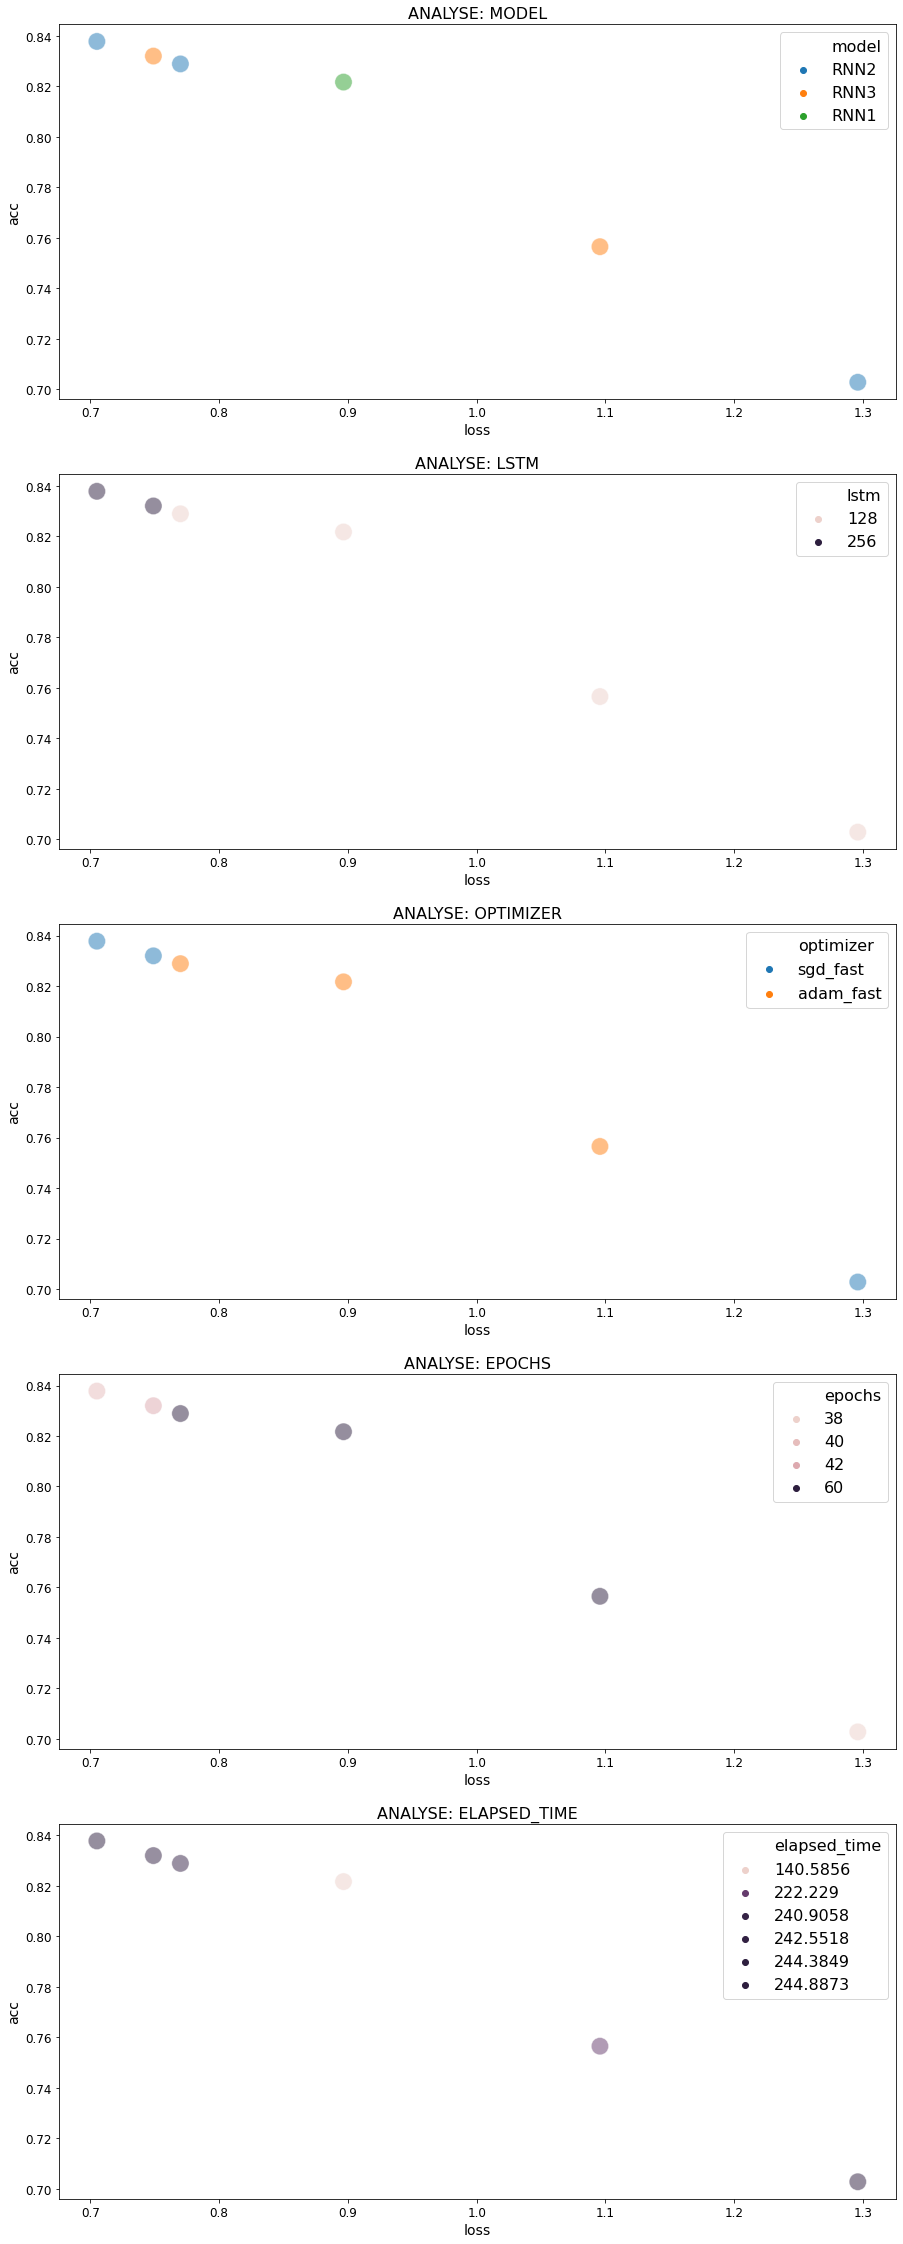

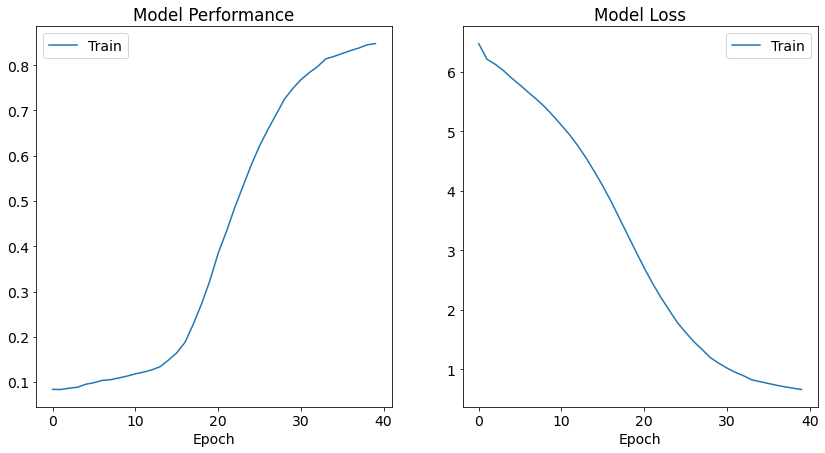

In [20]:
x, y, ign = 'loss', 'acc', ['id', 'loss']

printQuadrants(results, epochs, timeout, min_acc=0.7)
    
printHistory(best_history.history, metric='accuracy')

## Predição (Shakespeare mode ON)
Este modelo pode agora ser utilizado para  prever as próximas palavras:

In [12]:
def get_next_word(model, frase):
    sequences = tokenizer.texts_to_sequences([frase])
    padded = pad_sequences(sequences, maxlen=max_len , padding='pre', truncating='pre')
    predicted = model.predict_classes(padded)
    
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    return output_word
    
get_next_word(model, 'please, save me in this')  

','

Inclusive, podemos gerar uma sequencia maior de palavras para formar um novo soneto.

In [13]:
generate_words = 50

sentence = 'please, save me in this'
for i in range(generate_words):
    sentence = sentence + " " + get_next_word(model, sentence)
print(sentence)

please, save me in this , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,


Para uma determinada entrada, o modelo sempre vai responder a mesma palavra, o que não é interessante. Modifique a funcão `get_next_word` para retornar uma palavra com probabilidade igual à especificada pelo modelo.

Teste diversas possibilidades de arquitetura, com modelos bidirecionais, LSTM e GRUs, quais deles obtém um resultado melhor?


Após isso, tente treinar um modelo semelhante usando poemas de [Goncalves Dias](http://www.dominiopublico.gov.br/download/texto/bv000115.pdf)
